## Importing the libraries

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import dataframe_image as dfi

%matplotlib inline


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Saving the figures
PROJECT_ROOT_DIR = "."
PROJECT_NAME = "AirBnB-London-2020"
IMAGES_PATH = "../reports/figures/"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Reading in the data file

In [3]:
df_listings = pd.read_csv('../data/raw/listings.csv', dtype={'listing_url': 'object',
                                                      'price': 'object',
                                                      'weekly_price': 'object',
                                                      'monthly_price': 'object',
                                                      'security_deposit': 'object',
                                                      'cleaning_fee': 'object',
                                                      'extra_people': 'object',
                                                      'license': 'object', 
                                                      'jurisdiction_names': 'object',})

In [4]:
df_listings.shape

(86358, 106)

In [5]:
pd.set_option('display.max_columns', None)

# show listings data sample
df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20200414180850,2020-04-16,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,For art lovers I can give guest my Tate Member...,The flat only a 10 minute walk to Finsbury Par...,Guest will have access to the self catering ki...,I like to have little chats with my guest over...,I'm an artist and have my artwork up on the wa...,NaN,NaN,https://a0.muscache.com/im/pictures/ffb507b7-9...,NaN,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,71%,89%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,4.0,4.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",LB of Islington,Islington,NaN,Islington,Greater London,N4 3,London,"Islington, United Kingdom",GB,United Kingdom,51.56802,-0.11121,t,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",538.0,$65.00,$333.00,"$1,176.00",$100.00,$15.00,1,$15.00,1,29,1,1,29,29,1.0,29.0,12 months ago,t,27,57,84,359,2020-04-16,21,7,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,f,moderate,f,f,2,1,1,0,0.18
1,15400,https://www.airbnb.com/rooms/15400,20200414180850,2020-04-16,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,The building next door is in the process of be...,The underground stations are South Kensington ...,There are two wardrobes for guests exclusive u...,If I am in the country I like to welcome my gu...,NO SMOKING PLEASE.. No unauthorised guests. No...,NaN,NaN,https://a0.muscache.com/im/pictures/428392/462...,NaN,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",within a day,50%,67%,f,https://a0.musc

In [6]:
class format_data:
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def data_float(self):
        self = self.str.replace('$', '', regex=True).replace(',', '', regex=True).astype(float)
        
        return self
    
    def data_percentage(self):
        self = (self.str.replace('%', '', regex=True).astype('float')) / 100
        
        return self
    
    def dict_to_list(self):
        self = self.str.replace('{', '', regex=True).replace('}', '', regex=True).replace('\"', '', regex=True)
        self = self.str.split(',')
              
        return self

In [7]:
float_list = ['price','security_deposit','cleaning_fee','extra_people']
for x in float_list:
    df_listings[x] = format_data.data_float(df_listings[x])

In [8]:
float_list = ['host_response_rate','host_acceptance_rate']
for x in float_list:
    df_listings[x] = format_data.data_percentage(df_listings[x])

In [9]:
df_listings['amenities'] = format_data.dict_to_list(df_listings['amenities'])

## Data Exploration

In [10]:
df_listings.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,8.635800e+04,8.635800e+04,0.0,0.0,0.0,8.635800e+04,53473.000000,64813.000000,86348.000000,86348.000000,0.0,86358.000000,86358.000000,86358.000000,86226.000000,86216.000000,85416.000000,378.000000,86358.000000,56676.000000,64465.000000,86358.000000,86358.000000,86358.000000,8.635800e+04,86358.000000,86358.000000,8.635800e+04,8.635800e+04,86358.000000,8.635800e+04,86358.000000,86358.000000,86358.000000,86358.000000,86358.000000,86358.000000,63201.000000,63140.000000,63150.000000,63091.000000,63145.000000,63092.000000,63091.000000,86358.000000,86358.000000,86358.000000,86358.000000,64842.000000
mean,2.511516e+07,2.020041e+13,NaN,NaN,NaN,9.334733e+07,0.926660,0.830196,25.805450,25.805450,NaN,51.509916,-0.128245,3.211793,1.312122,1.415399,1.756580,643.611111,129.610725,191.465806,43.886109,1.610760,7.339644,4.474490,1.859559e+04,4.611142,5.812895,4.352354e+04,6.403469e+05,5.213305,6.099044e+05,7.870944,20.663239,33.379201,116.328898,17.531277,6.039417,92.491938,9.498464,9.256089,9.619375,9.642949,9.545346,9.253428,20.987448,17.973506,2.392390,0.052224,0.963183
std,1.238307e+07,1.269929e+01,NaN,NaN,NaN,9.543753e+07,0.183485,0.254690,134.219607,134.219607,NaN,0.046204,0.093286,2.033954,0.611861,0.920860,1.291133,849.684376,289.484146,322.896383,46.501627,1.368455,14.194697,19.151568,3.843374e+06,25.141390,29.128662,8.256667e+06,3.673454e+07,27.244416,3.496024e+07,10.379774,22.536341,35.047341,135.293902,37.393948,11.836707,10.357702,1.007258,1.156111,0.917570,0.913096,0.834854,1.057238,100.232081,98.678139,13.027134,0.712945,1.177591
min,1.391300e+04,2.020041e+13,NaN,NaN,NaN,4.775000e+03,0.000000,0.000000,0.000000,0.000000,NaN,51.294790,-0.510310,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.553035e+07,2.020041e+13,NaN,NaN,NaN,1.636343e+07,0.950000,0.760000,1.000000,1.000000,NaN,51.485850,-0.188380,2.000000,1.000000,1.000000,1.000000,130.000000,47.000000,0.000000,15.000000,1.000000,0.000000,1.000000,3.100000e+01,1.000000,1.000000,6.000000e+01,9.000000e+01,1.000000,8.500000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.200000
50%,2.573346e+07,2.020041e+13,NaN,NaN,NaN,5.013476e+07,1.000000,0.960000,1.000000,1.000000,NaN,51.514080,-0.126245,2.000000,1.000000,1.000000,1.000000,522.000000,83.000000,100.000000,30.000000,1.000000,0.000000,2.000000,1.125000e+03,2.000000,2.000000,1.125000e+03,1.125000e+03,2.000000,1.125000e+03,0.000000,8.000000,16.000000,63.000000,4.000000,1.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,1.000000,0.000000,0.560000
75%,3.654165e+07,2.020041e+13,NaN,NaN,NaN,1.522947e+08,1.000000,1.000000,5.000000,5.000000,NaN,51.537620,-0.069930,4.000000,1.

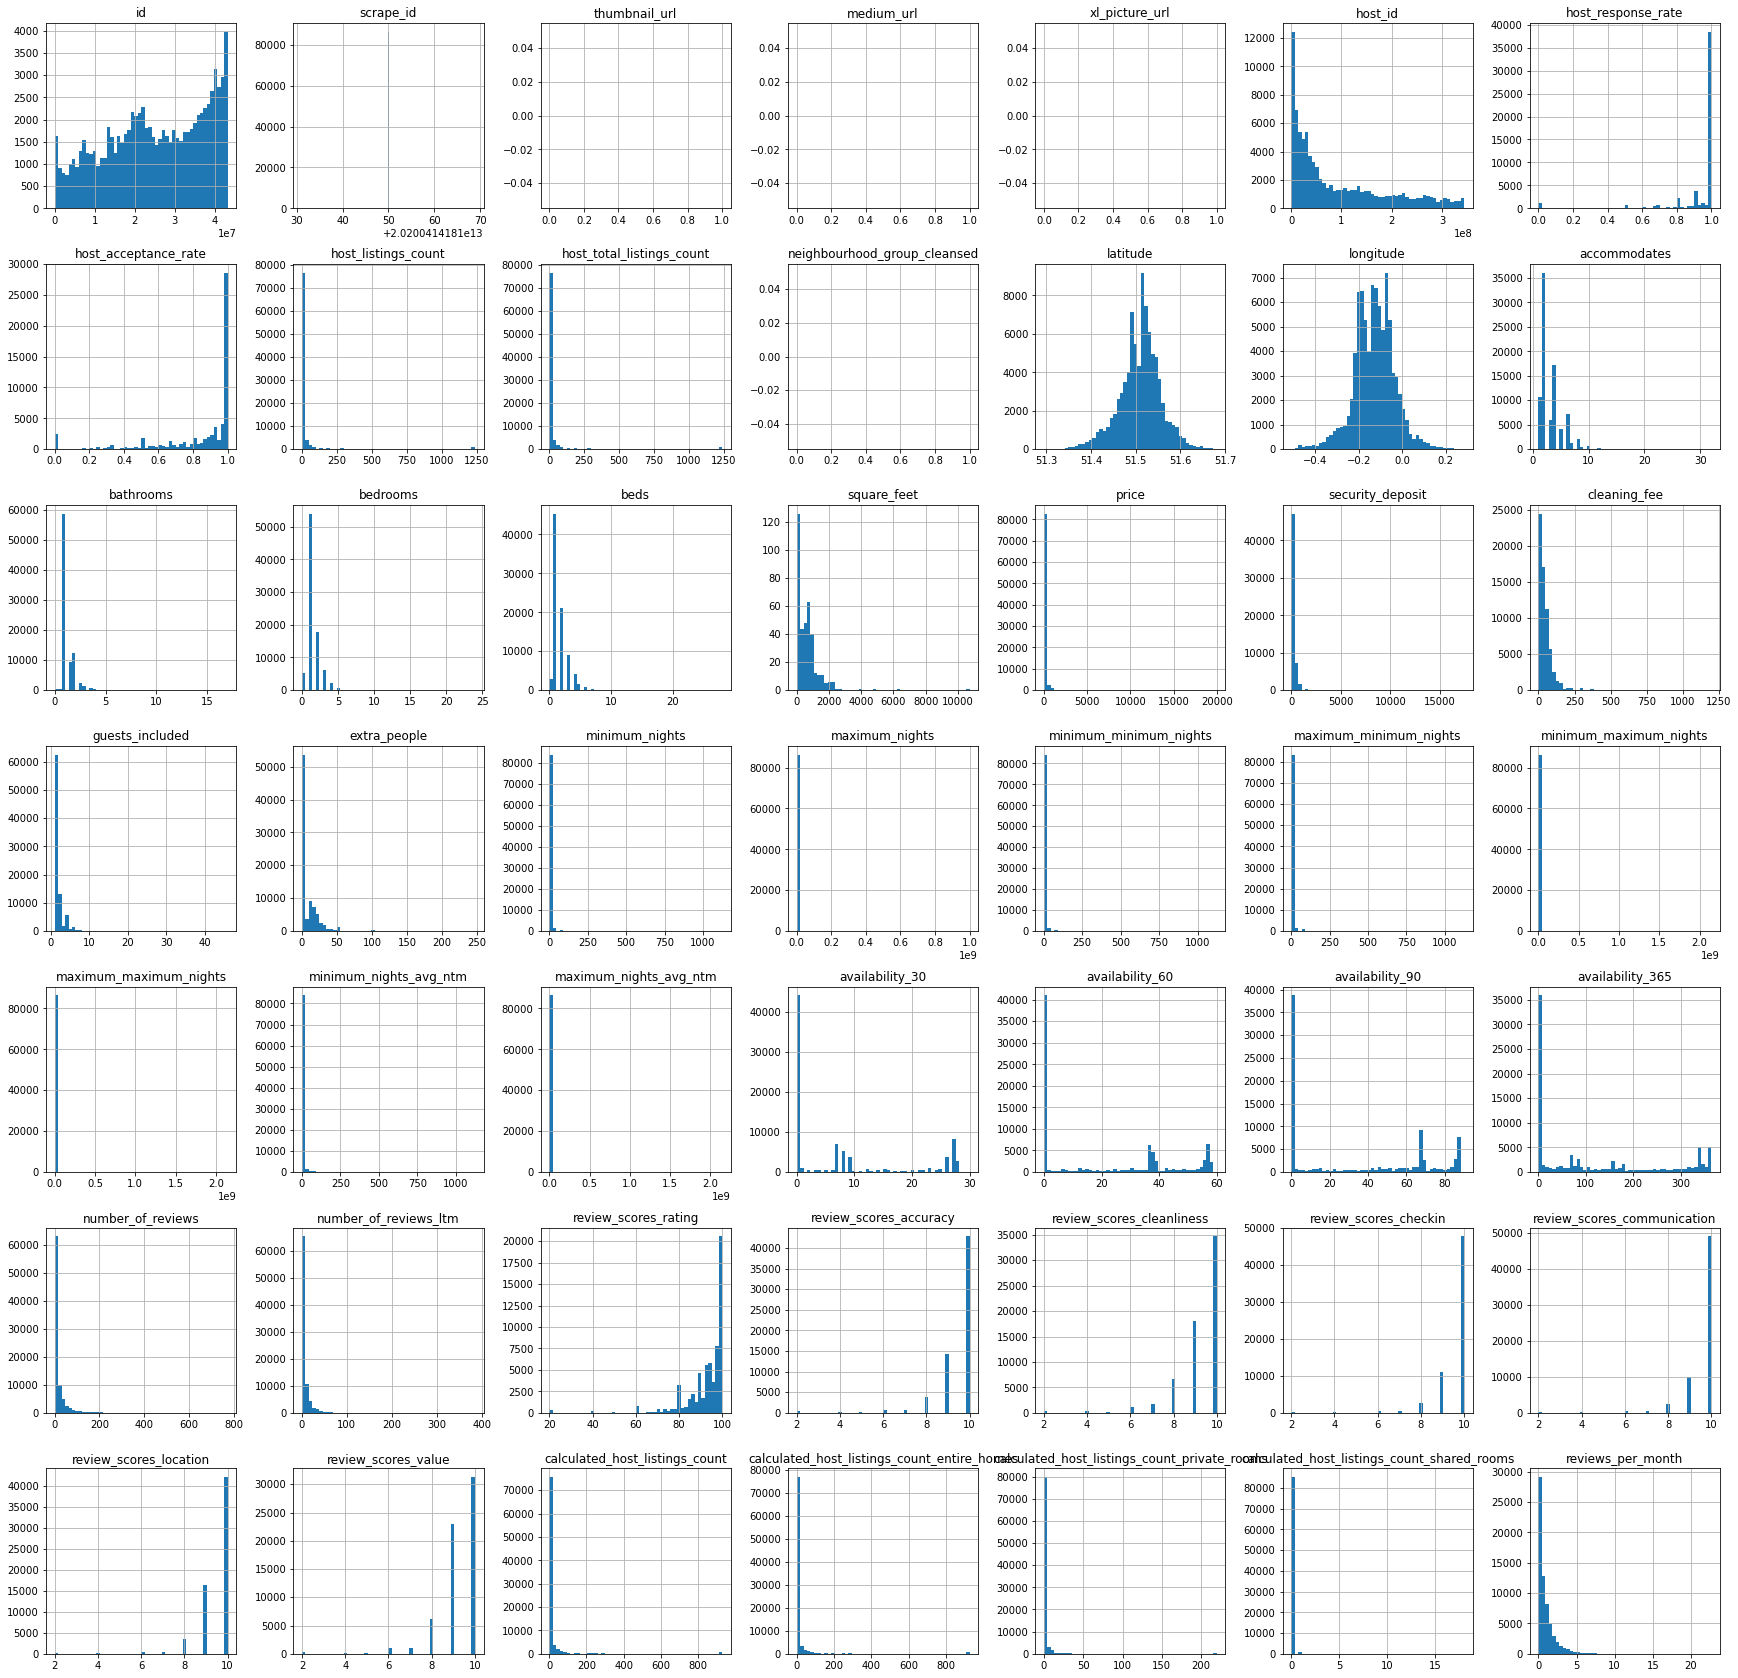

In [11]:
df_listings.hist(bins=50, figsize=(30,30))
plt.show()

In [12]:
set(df_listings.columns[df_listings.isnull().mean()>0.75])

{'jurisdiction_names',
 'license',
 'medium_url',
 'monthly_price',
 'neighbourhood_group_cleansed',
 'square_feet',
 'thumbnail_url',
 'weekly_price',
 'xl_picture_url'}

### Removing Price Outliers

In [13]:
def find_outliers(df_listings):
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df_listings["price"], 25)
    
    #Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df_listings["price"],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    #print("Data points considered outliers for the feature '{}':".format("price"))
    filtered_data = df_listings[~((df_listings["price"] >= Q1 - step) & 
                                  (df_listings["price"] <= Q3 + step))].sort_values(by=["price"])
                                  
    #filtered_data["price"].hist()
    #outliers = filtered_data[filtered_data["price"] >= 1000.00]
    
    return filtered_data
                                  
                                  
outliers = find_outliers(df_listings).index
                                  
df_listings = df_listings.drop(df_listings.index[outliers]).reset_index(drop = True)

<AxesSubplot:>

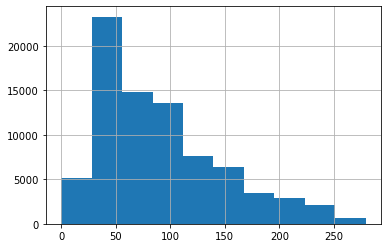

In [14]:
df_listings["price"].hist()

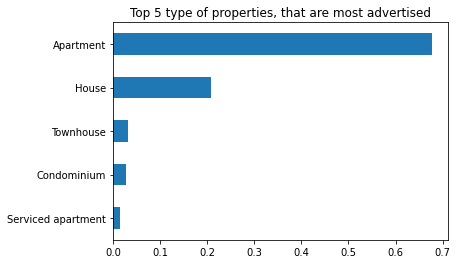

In [15]:
neighbourhood_vals = df_listings['property_type'].value_counts()

# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.

((neighbourhood_vals[0:5]/df_listings.shape[0]).sort_values()).plot(kind="barh");
plt.title("Top 5 type of properties, that are most advertised");

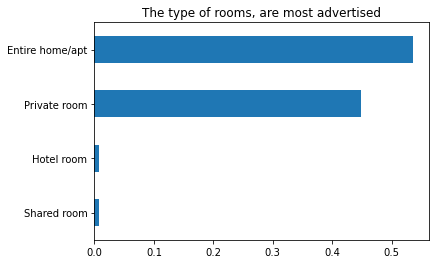

In [16]:
room_vals = df_listings['room_type'].value_counts()

# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.

((room_vals/df_listings.shape[0]).sort_values()).plot(kind="barh");
plt.title("The type of rooms, are most advertised");

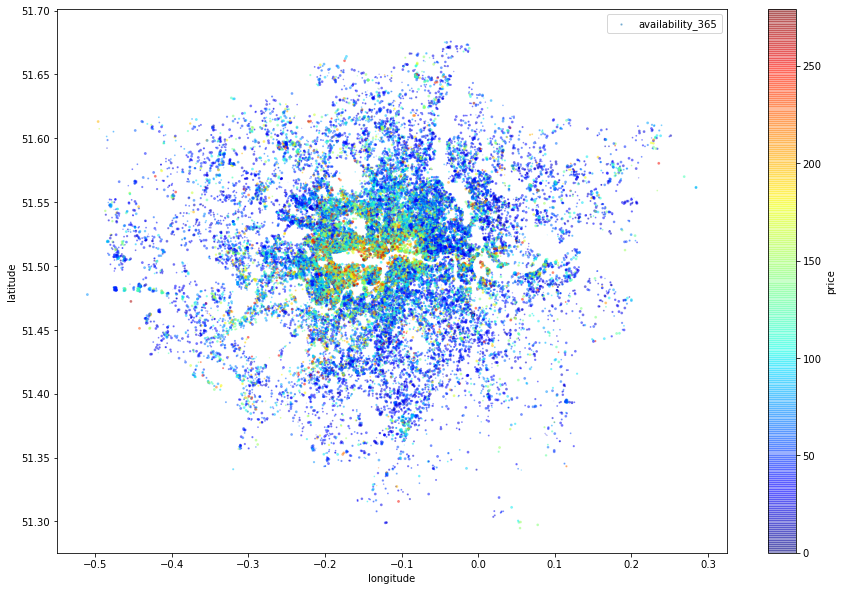

In [17]:
df_listings.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, figsize=(15,10),
                 s=(df_listings["availability_365"])/100, label="availability_365", 
                 c="price", cmap=plt.get_cmap('jet'), 
                 colorbar=True,
                 sharex=False)
plt.show()

Saving figure availability_365_prices_scatterplot


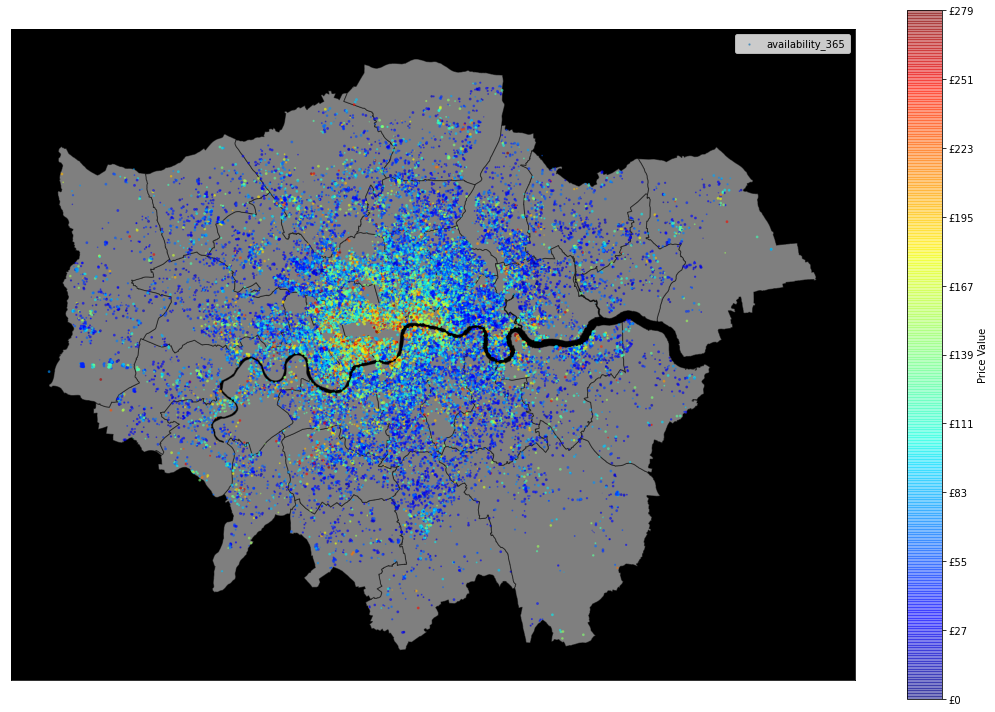

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

basemap = gpd.read_file('../data/external/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
basemap = basemap.to_crs(epsg=4326)


basemap = basemap.plot(alpha=0.5, edgecolor='k',color='White',figsize=(15,10),ax=ax)
basemap.set_facecolor('black')


x, y = df_listings['longitude'].values, df_listings['latitude'].values
basemap.scatter(x,y, alpha=0.5,
                 s=(df_listings["availability_365"])/100, label="availability_365", 
                 c=df_listings["price"], cmap=plt.get_cmap('jet'))


sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'))
prices = df_listings["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = fig.colorbar(sm, ticks=tick_values/prices.max(), alpha=0.5)
cbar.ax.set_yticklabels(["£%d"% v for v in tick_values], fontsize=10)
cbar.set_label('Price Value', fontsize=10)

# Removing ticks
plt.xticks([]),
plt.yticks([])

plt.legend(fontsize=10)
save_fig("availability_365_prices_scatterplot")
plt.show()

### What is the average price of the listings, for the different location within London?

In [19]:
price_df = df_listings[df_listings['price'].isnull() == False]

In [20]:
price_df['neighbourhood_cleansed'].value_counts()[:5]

Tower Hamlets             8062
Westminster               8039
Hackney                   6022
Camden                    5619
Kensington and Chelsea    4976
Name: neighbourhood_cleansed, dtype: int64

In [21]:
nb_price_avg = price_df.groupby('neighbourhood_cleansed', as_index=False).mean()
nb_price_avg = pd.DataFrame(nb_price_avg).sort_values(by='price', ascending=False)

In [22]:
nb_price_avg = nb_price_avg.rename(columns={'neighbourhood_cleansed':'Neighbourhood','price': 'Avg Price'})

In [23]:
def chart_plot(data, x_label, y_label):
    
    plt.figure(figsize=(10,5))

    sns.set(style="whitegrid")
    chart = sns.barplot(x=x_label, y=y_label, data=data)

    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=60, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='medium', 
        rotation_mode='anchor'
    )

Saving figure Neighbourhood_av_price_histogram_plots


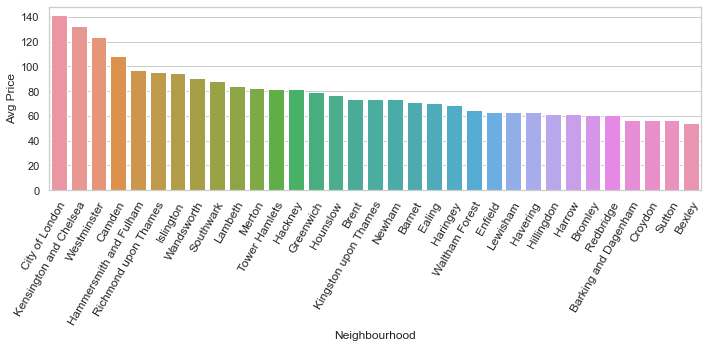

In [24]:
chart_plot(nb_price_avg,"Neighbourhood", "Avg Price")
save_fig("Neighbourhood_av_price_histogram_plots")

### What types of verifications are hosts using? How long did it take them to respond?

In [25]:
verifications_df = df_listings[df_listings['host_verifications'].isnull() == False]

In [26]:
verifications_df = verifications_df[verifications_df['host_verifications'] != '[]']

In [27]:
def verifications_types(column):
    verifications_dict = {}
    temp = []

    for i in column:
        temp.append(eval(i))
    
    for i in temp:
        try:
            for j in i:
                if j not in verifications_dict:
                    verifications_dict[j] = 1
                else:
                    verifications_dict[j] += 1
        except:
            continue
            
    return verifications_dict
        
verifications_types = verifications_types(verifications_df['host_verifications'])

In [28]:
for k,v in verifications_types.items():
    verifications_types[k] = round(v / verifications_df.shape[0] * 100, 3)

In [29]:
verifications_types = pd.DataFrame.from_dict(verifications_types,orient='index',columns=['A']).reset_index()
verifications_types = verifications_types.rename(columns={'index':'Verification Type','A': '% of listings'})
top10_verifications_types = verifications_types.sort_values(by='% of listings', ascending=False)[:10]

Saving figure Verification_type_price_histogram_plots


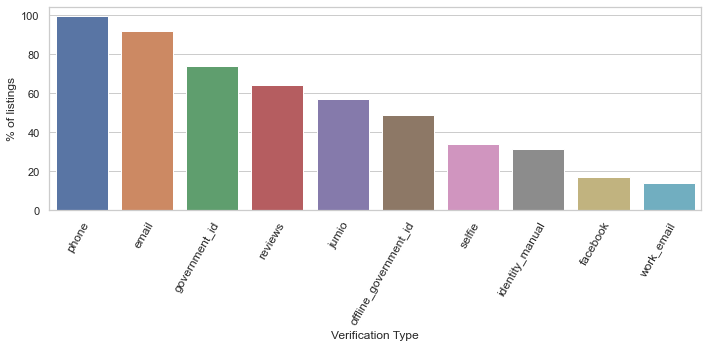

In [30]:
chart_plot(top10_verifications_types,"Verification Type", "% of listings")
save_fig("Verification_type_price_histogram_plots")

### What amenities are most used and does the count of amenities affect the review? 

In [31]:
df_left = df_listings[['id','amenities']]

In [32]:
df_right = df_listings[['id','review_scores_value']]

In [33]:
df_left.head()

,id,amenities
0,13913,"[TV, Cable TV, Wifi, Kitchen, Paid parking off..."
1,15400,"[TV, Cable TV, Internet, Wifi, Air conditionin..."
2,17506,"[TV, Internet, Wifi, Air conditioning, Breakfa..."
3,25023,"[TV, Wifi, Kitchen, Free parking on premises, ..."
4,25123,"[Wifi, Kitchen, Free street parking, Buzzer/wi..."


In [34]:
df_left = df_left.amenities.apply(pd.Series).merge(df_left, right_index = True, 
                                         left_index = True) \
                                  .drop(["amenities"], axis = 1) \
                                  .melt(id_vars = ['id'], value_name = "amenities") \
                                  .drop("variable", axis = 1) \
                                  .dropna()

In [35]:
result = pd.merge(df_left, df_right, on='id')

In [36]:
result = result.groupby('amenities').agg({'review_scores_value': ['count', 'min', 'max', 'mean']})

In [37]:
result = result.reset_index()

In [38]:
result.head().columns

MultiIndex([(          'amenities',      ''),
            ('review_scores_value', 'count'),
            ('review_scores_value',   'min'),
            ('review_scores_value',   'max'),
            ('review_scores_value',  'mean')],
           )

In [39]:
result = result.sort_values(by=[('review_scores_value', 'mean'),
                                ('review_scores_value',  'min'),
                                ('review_scores_value',  'max')], ascending=False)

In [40]:
result.columns = ["_".join(x) for x in result.columns.ravel()]

In [41]:
result.head().columns

Index(['amenities_', 'review_scores_value_count', 'review_scores_value_min',
       'review_scores_value_max', 'review_scores_value_mean'],
      dtype='object')

In [42]:
result.rename(columns={"amenities_":"Amenities", 
                       "review_scores_value_count":"Count Listings",
                       "review_scores_value_min":"Review Min Value",
                       "review_scores_value_max":"Review Max Value",
                       "review_scores_value_mean":"Review Avg Value"}, inplace=True)

In [43]:
result.head()

,Amenities,Count Listings,Review Min Value,Review Max Value,Review Avg Value
23,Beach view,1,10.0,10.0,10.0
62,Electric profiling bed,1,10.0,10.0,10.0
127,Mobile hoist,2,10.0,10.0,10.0
128,Mountain view,2,10.0,10.0,10.0
164,Shared gym,2,10.0,10.0,10.0


In [44]:
result = result[result['Count Listings'] > 10]

In [45]:
result = result.head(20).style.background_gradient() \
               .format({"Amenities": lambda x:x.lower()}) \
               .format({"Review Min Value": "{:20,.2f}"}) \
               .format({"Review Max Value": "{:20,.2f}"}) \
               .format({"Review Avg Value": "{:20,.2f}"}) \
               .hide_index()\
               .background_gradient(cmap='Blues')

In [46]:
result.set_properties(subset=["Amenities", 
                              "Count Listings", 
                              "Review Min Value", 
                              "Review Max Value", 
                              "Review Avg Value"], **{'text-align': 'left'}) \
      .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

Amenities,Count Listings,Review Min Value,Review Max Value,Review Avg Value
murphy bed,16,9.00,10.00,9.75
convection oven,79,9.00,10.00,9.75
outdoor seating,96,8.00,10.00,9.74
wine cooler,26,9.00,10.00,9.73
heated floors,89,7.00,10.00,9.73
sound system,102,9.00,10.00,9.71
formal dining area,53,8.00,10.00,9.70
printer,33,9.00,10.00,9.70
terrace,81,9.00,10.00,9.68
en suite bathroom,112,8.00,10.00,9.68


In [47]:
dfi.export(result, '../reports/figures/top_amenities.png')

### What features assist in the pricing of a listing? 
- Could the price be predicted?
- importance of the features, rank features

### Preparing data

In [48]:
# Creating the 'amenities - count' column
df_listings['amenities - count'] = [len(i) for i in df_listings['amenities']]

In [49]:
def fill_na_data(df_listings):
    
    # filling float or int columns with the mean value of the column
    num_vars = df_listings.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df_listings[col].fillna((df_listings[col].mean()), inplace=True)
        
        
    # filling the categorial columns with text
    df_listings['host_response_time'].fillna('No Response', inplace=True)
    df_listings['host_is_superhost'].fillna('f', inplace=True)
    df_listings['host_has_profile_pic'].fillna('f', inplace=True)
    df_listings['bed_type'].fillna('Unknown', inplace=True)
    
    return df_listings

df_listings = fill_na_data(df_listings)

In [50]:
def drop_columns(df_listings):
    
    # Dropping Columns that aren't needed
    regex_list = ['url','id','scraped','first_review','last_review']
    for i in regex_list:
        df_listings = df_listings[df_listings.columns.drop(list(df_listings.filter(regex=i)))]
        
    df_listings = df_listings.drop(columns=['name','summary','space','description','neighborhood_overview','notes',
                                            'transit','access','interaction','house_rules','host_name','host_about',
                                            'latitude','longitude','host_since','host_neighbourhood','street',
                                            'neighbourhood','market','host_location','city','state','zipcode',
                                            'smart_location','country_code','country','amenities', 'host_verifications'])
    
    # remove columns with 70% or high with missing data
    col_nulls = set(df_listings.columns[df_listings.isnull().mean()>0.70])
    df_listings = df_listings.drop(list(col_nulls), axis=1)
    
    return df_listings

df_listings = drop_columns(df_listings)

In [51]:
# Removing rows that do not have a price
# df = df_listings.dropna(subset=["price"])
df = df_listings[df_listings['price'] != 0]

In [53]:
# Dummy the categorical variables
cat_vars = df.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    # for each cat add dummy var, drop original column
    df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var],
                                                         prefix=var, prefix_sep='_', drop_first=True)], axis=1)

## Building the Model

In [ ]:
# Extract features and labels
features = df.drop('price', axis = 1)
labels = df['price']

# List of features for later use
feature_list = list(features.columns)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_regression
#fs = SelectKBest(score_func=f_regression, k=200)

#X_selected = fs.fit_transform(X, y)
#print(X_selected)

In [ ]:
#X_new.shape

In [ ]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state=42)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

### Fittng the training data with various models

In [ ]:
def model_fit(model,X_train,y_train):
    
    model.fit(X_train,y_train)
    
    return model

In [ ]:
def model_rmse(model, X_test, y_test):
    predictions = model.predict(X_test) 
    mse = mean_squared_error(y_test,predictions) 
    rmse = np.sqrt(mse) 
    
    return rmse

In [ ]:
def model_accurancy(model, X_test, y_test):
    
    # Make predictions on test data using the model trained on original data
    predictions = model.predict(X_test) 
    
    # Performance metrics
    errors = abs(y_test - predictions)
    
    # Average absolute error metric
    print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
    
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    
    print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
# Linear Regression
lin_reg = LinearRegression()
model_fit(lin_reg, X_train, y_train)

In [ ]:
# Linear Regression - RMSE
model_rmse(lin_reg, X_test, y_test)

In [ ]:
# Linear Regression - model accurancy
model_accurancy(lin_reg, X_test, y_test)

In [ ]:
# Decision Tree Regression
tree_reg = DecisionTreeRegressor()
model_fit(tree_reg, X_train, y_train)

In [ ]:
# Decision Tree Regression - RMSE
model_rmse(tree_reg, X_test, y_test)

In [ ]:
# Decision Tree Regression - model_accurancy
model_accurancy(tree_reg, X_test, y_test)

In [ ]:
# Random Forest Regression
forest_reg = RandomForestRegressor()
model_fit(forest_reg, X_train, y_train)

In [ ]:
# Random Forest Regression - RMSE
model_rmse(forest_reg, X_test, y_test)

In [ ]:
# Random Forest Regression - modelmodel_accurancyrancyy
model_accurancy(forest_reg, X_test, y_test)

### Finding the scores, mean and standard variations of the different models

In [ ]:
def display_scores(model,X_train,y_train):
    
    scores = cross_val_score(model,X_train,y_train,scoring = "neg_mean_squared_error",cv = 10, n_jobs=-1)
    model_rmse_scores = np.sqrt(-scores) 
    
    print("Scores:",model_rmse_scores)
    print("Mean:",model_rmse_scores.mean())
    print ("Standard deviation:",model_rmse_scores.std())

In [ ]:
# Linear Regression
display_scores(lin_reg,X_train,y_train)

In [ ]:
# Decision Tree Regression
display_scores(tree_reg,X_train,y_train)

In [ ]:
# Random Forest Regression
display_scores(forest_reg,X_train,y_train)

### Explore Number of Features

In [ ]:
def open_file(file_name):
    
    open_file = open(file_name, "rb")
    my_results, my_names = pickle.load(open_file)
    open_file.close()
    
    for name, scores in zip(my_names, my_results):
        # summarize the performance along the way
        print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
       
    return my_results, my_names

In [ ]:
# plot model performance for comparison
plt.boxplot(my_results, labels=my_names, showmeans=True)
plt.show()

### Explore Number of Trees

In [ ]:
tree_results, tree_names = open_file("eval_tree_models.pickle")

# plot model performance for comparison
plt.boxplot(tree_results, labels=tree_names, showmeans=True)
plt.show()

### Explore Tree Depth

In [ ]:
depth_results, depth_names = open_file("eval_depth_models.pickle")

# plot model performance for comparison
plt.boxplot(depth_results, labels=depth_names, showmeans=True)
plt.show()

### GridSearchCV - Finding the best parameters

In [ ]:
# Importing the trained model 
with open("../models/final_model.pickle", 'rb') as handle:
    final_model = pickle.load(handle)

In [ ]:
best_params = final_model.best_params_
cv_results = final_model.cv_results_
feature_importances = final_model.best_estimator_._final_estimator.feature_importances_
final_model = final_model.best_estimator_

In [ ]:
best_params

In [ ]:
# Finding the feature importance
# feature_importances

In [ ]:
# Display the feature importance scores
# extra_attribs = ["rooms_per_hhold","pop_per_hhold","bedrooms_per_room"]
# cat_encoder = full_pipeline.named_transformers_ ["cat"]
# cat_one_hot_attribs = list(cat_encoder.categories_[0])
# attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances,X_train.columns),reverse = True) 

In [ ]:
cv_results = final_model.cv_results_

for mean_score, params in zip (cv_results["mean_test_score"], cv_results["params"]):
    print(round(np.sqrt(-mean_score),2),params)

In [ ]:
# Evaluate the system on the test set
model_rmse(final_model, X_test, y_test)